In [ ]:
!pip install neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.1 MB/s eta 0:00:00
  Created wheel for torch-harmonics: filename=torch_harmonics-0.7.3-py3-none-any.whl size=87749 sha256=6a25f3b9c223a11388e36dcadcd7ff846000f040d2b0eb24d

In [ ]:
!git clone https://github.com/neuraloperator/neuraloperator.git

Cloning into 'neuraloperator'...
remote: Enumerating objects: 13981, done.
remote: Counting objects: 100% (1416/1416), done.
remote: Compressing objects: 100% (482/482), done.
remote: Total 13981 (delta 1158), reused 934 (delta 934), pack-reused 12565 (from 3)
Receiving objects: 100% (13981/13981), 108.93 MiB | 54.33 MiB/s, done.
Resolving deltas: 100% (9198/9198), done.


In [ ]:
!cd neuraloperator

In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [ ]:
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.data.datasets.car_cfd_dataset import CarCFDDataset

In [ ]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
# data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [ ]:
import os

path = "/usr/local/lib/python3.12/dist-packages/neuralop/data/datasets/data"

# Split the path into folders
folders = path.split(os.sep)
print(folders)

['', 'usr', 'local', 'lib', 'python3.12', 'dist-packages', 'neuralop', 'data', 'datasets', 'data']


In [ ]:
# All items in the folder
items = os.listdir(path)

# Separate files and folders
files = [name for name in items if os.path.isfile(os.path.join(path, name))]
folders = [name for name in items if os.path.isdir(os.path.join(path, name))]

print("Files:", files)
print("Number of files:", len(files))
print("Folders:", folders)
print("Number of folders:", len(folders))

Files: ['darcy_test_32.pt', 'darcy_test_16.pt', 'darcy_train_16.pt']
Number of files: 3
Folders: []
Number of folders: 0


In [ ]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [ ]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [ ]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [ ]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [ ]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [ ]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/usr/local/lib/python3.12/dist-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.

Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=7.19, avg_loss=0.5967, train_err=18.6459
Eval: 16_h1=0.3751, 16_l2=0.2541, 32_h1=0.5426, 32_l2=0.2676
[3] time=5.61, avg_loss=0.2105, train_err=6.5793
Eval: 16_h1=0.2001, 16_l2=0.1388, 32_h1=0.4773, 32_l2=0.1774
[6] time=6.04, avg_loss=0.1764, train_err=5.5137
Eval: 16_h1=0.2341, 16_l2=0.1643, 32_h1=0.4901, 32_l2=0.2013
[9] time=6.43, avg_loss=0.1792, train_err=5.6012
Eval: 16_h1=0.2126, 16_l2=0.1377, 32_h1=0.4660, 32_l2=0.1645
[12] time=5.68, avg_loss=0.1339, train_err=4.1833
Eval: 16_h1=0.2182, 16_l2=0.1291, 32_h1=0.5305, 32_l2=0.1642
[15] time=6.28, avg_loss=0.1211, train_err=3.7854
Eval: 16_h1=0.2271, 16_l2=0.1393, 32_h1=0.4704, 32_l2=0.1695
[18] time=5.63, avg_loss=0.0976, train_err=3.0501
Eval: 16_h1=0.1945, 16_l2=0.1119, 32_h1=0.4996, 32_l2=0.1520


{'train_err': 2.884589731693268,
 'avg_loss': 0.09230687141418457,
 'avg_lasso_loss': None,
 'epoch_train_time': 6.280732410999917}

/usr/local/lib/python3.12/dist-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/usr/local/lib/python3.12/dist-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out_ff

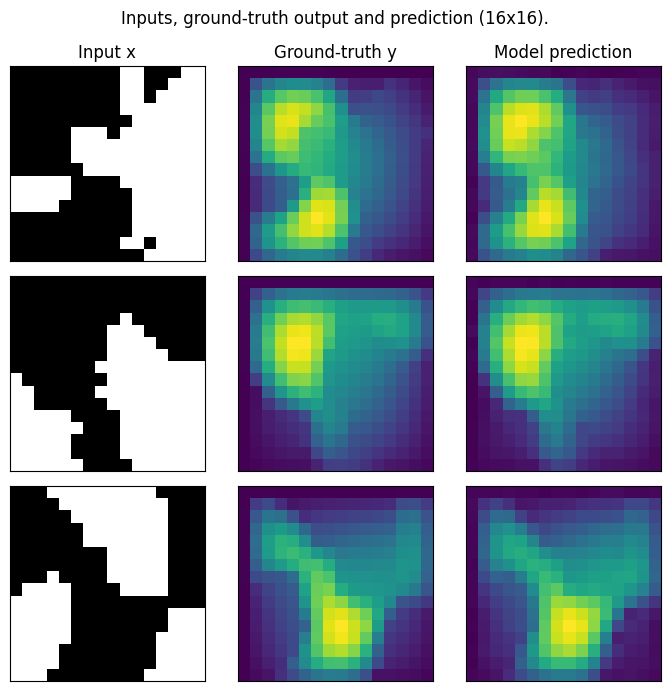

In [ ]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

/usr/local/lib/python3.12/dist-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/usr/local/lib/python3.12/dist-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out_ff

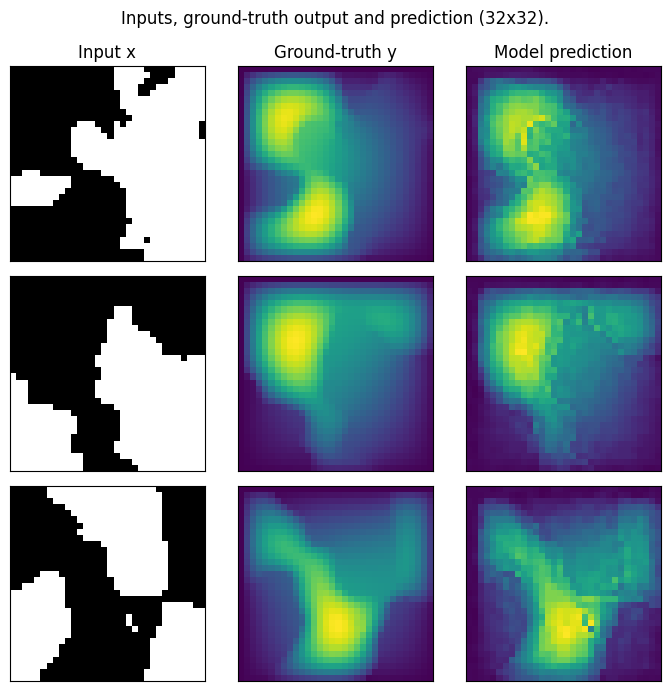

In [ ]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()

In [ ]:
# import shutil
# shutil.move('/content/darcy_test_32.pt',path)

'/usr/local/lib/python3.12/dist-packages/neuralop/data/datasets/data/darcy_test_32.pt'